## Background

This Jupyter document shows how to merge two directed graphs, G1 and G2, and to identify their common subgraphs. This template can be used to compare Arches Resource Models (graph-based reference data) from different projects (see the abstract: https://github.com/achp-project/cultural-heritage/issues/6)

Import libraries

In [134]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Create the Directed graphs (DiGraphs) G1 and G2, from nodes and edges lists

In [135]:
# G1
G1 = nx.DiGraph()
G1.add_nodes_from([1, 2, 3, 4])
G1_attrs_nodes = {1: {"entity": 'E27'}, 2: {"entity": 'E53'}, 3:{"entity": 'E2'}, 4:{"entity": 'E7'}}
nx.set_node_attributes(G1, G1_attrs_nodes)

G1.add_edges_from([(1, 2), (2, 3), (3, 4)])
G1_attrs_edges = {(1, 2): {"property": 'P53'}, (2, 3): {"property": 'P4'}, (3, 4):{"property": 'P5'}}
nx.set_edge_attributes(G1, G1_attrs_edges)

# G2
G2 = nx.DiGraph()
G2.add_nodes_from([1, 2, 3, 4])
G2_attrs_nodes = {1: {"entity": 'E27'}, 2: {"entity": 'E53'}, 3:{"entity": 'E2'}, 4:{"entity": 'E7'}}
nx.set_node_attributes(G2, G2_attrs_nodes)

G2.add_edges_from([(1, 2), (2, 3), (4, 3)])
G2_attrs_edges = {(1, 2): {"property": 'P53'}, (2, 3): {"property": 'P1'}, (4, 3):{"property": 'P5'}}
nx.set_edge_attributes(G2, G2_attrs_edges)

Print G1 and G2 lists of nodes and edges:

In [136]:
def print_edges_attributes(digraph):
    edge_data = []
    for u, v, attrs in G1.edges(data=True):
        edge_info = {
            "Source": u,
            "Target": v,
            **attrs
        }
        edge_data.append(edge_info)
    edge_df = pd.DataFrame(edge_data)
    print(edge_df.to_markdown())

def print_nodes_attributes(digraph):
    node_data = []
    for node, attrs in G1.nodes(data=True):
        node_info = {
            "Node": node,
            **attrs
        }
        node_data.append(node_info)
    node_df = pd.DataFrame(node_data)
    print(node_df.to_markdown())

G1:

In [137]:
print("nodes")
print_nodes_attributes(G1)
print("\nedges")
print_edges_attributes(G1)

nodes
|    |   Node | entity   |
|---:|-------:|:---------|
|  0 |      1 | E27      |
|  1 |      2 | E53      |
|  2 |      3 | E2       |
|  3 |      4 | E7       |

edges
|    |   Source |   Target | property   |
|---:|---------:|---------:|:-----------|
|  0 |        1 |        2 | P53        |
|  1 |        2 |        3 | P4         |
|  2 |        3 |        4 | P5         |


G2:

In [138]:
print("nodes")
print_nodes_attributes(G2)
print("\nedges")
print_edges_attributes(G2)

nodes
|    |   Node | entity   |
|---:|-------:|:---------|
|  0 |      1 | E27      |
|  1 |      2 | E53      |
|  2 |      3 | E2       |
|  3 |      4 | E7       |

edges
|    |   Source |   Target | property   |
|---:|---------:|---------:|:-----------|
|  0 |        1 |        2 | P53        |
|  1 |        2 |        3 | P4         |
|  2 |        3 |        4 | P5         |


Plot G1 and G2:

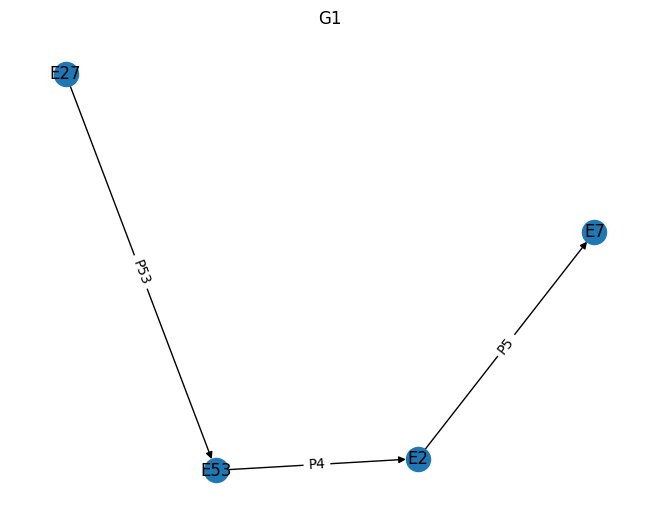

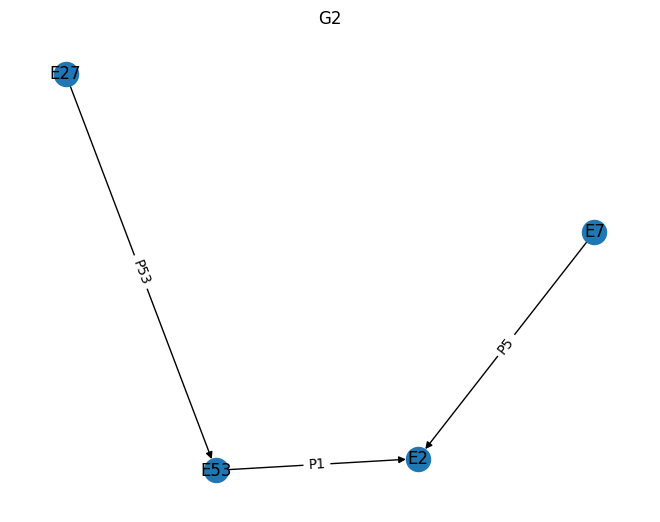

In [139]:
# Plot G1

p = nx.spring_layout(G1)

G1_labels_nodes = nx.get_node_attributes(G1, 'entity')
G1_labels_edges = nx.get_edge_attributes(G1, 'property')
nx.draw(G1, pos=p, labels = G1_labels_nodes, with_labels = True)
nx.draw_networkx_edge_labels(G1, pos=p, edge_labels = G1_labels_edges)
plt.title("G1")
plt.show()

# Plot G2

G2_labels_nodes = nx.get_node_attributes(G2, 'entity')
G2_labels_edges = nx.get_edge_attributes(G2, 'property')
nx.draw(G2, pos=p, labels = G2_labels_nodes, with_labels = True)
nx.draw_networkx_edge_labels(G2, pos=p, edge_labels = G2_labels_edges)
plt.title("G2")
plt.show()

## Table views

Rearrange attributes and nodes identifiers in a RDF-like structure

In [140]:
# store
lg = []
dn = list()
ct = 0
for i in [G1, G2]:
	ct = ct + 1
	df_edges = nx.to_pandas_edgelist(i)
	df_nodes = []
	for a,b in i.nodes(data = True):
		df_nodes.append(
			{
				'node_id': a,
				'entity': b['entity']
			}
		)
	df_nodes=pd.DataFrame(df_nodes)
	# map
	id_to_entity = dict(zip(df_nodes['node_id'], df_nodes['entity']))
	df_subgraph = df_edges
	df_subgraph['source'] = df_edges['source'].map(id_to_entity)
	df_subgraph['target'] = df_edges['target'].map(id_to_entity)
	lg.append(df_subgraph)
	# keep the list of id nodes
	df_nodes['G'] = str(ct)
	dn.append(df_nodes)

df_G1 = lg[0]
df_G2 = lg[1]
dn_all = pd.concat([dn[0], dn[1]])
# clean
dn_all = dn_all.reset_index()
dn_all = dn_all.drop('index', axis = 1)

G1:

In [141]:
print(df_G1.to_markdown())

|    | source   | target   | property   |
|---:|:---------|:---------|:-----------|
|  0 | E27      | E53      | P53        |
|  1 | E53      | E2       | P4         |
|  2 | E2       | E7       | P5         |


G2:

In [142]:
print(df_G2.to_markdown())

|    | source   | target   | property   |
|---:|:---------|:---------|:-----------|
|  0 | E27      | E53      | P53        |
|  1 | E53      | E2       | P1         |
|  2 | E7       | E2       | P5         |


Common rows between G1 and G2

In [143]:
df_G1xG2 = df_G1.merge(df_G2, how='outer', indicator=True)
df_G1_only = df_G1xG2[df_G1xG2['_merge'] == 'left_only']
df_G2_only = df_G1xG2[df_G1xG2['_merge'] == 'right_only']
df_G_both = df_G1xG2[df_G1xG2['_merge'] == 'both']
print("\n")
print(df_G_both.to_markdown())



|    | source   | target   | property   | _merge   |
|---:|:---------|:---------|:-----------|:---------|
|  0 | E27      | E53      | P53        | both     |


In [144]:

# nodes with create 'match' column
dn_all_match = dn_all 
dn_all_match['match'] = dn_all_match["entity"] + '_' + dn_all_match["G"]
# add new node_id for the merge
dn_all_match['id'] = range(len(dn_all_match))
dn_all_match['id'] = dn_all_match['id']+1
# dn_all_match = dn_all_match.drop(['entity', 'G'], axis = 1)
dn_all_match = dn_all_match.drop(['entity'], axis = 1)
# print("\n")
# print(dn_all_match.to_markdown())

Merge G1 and G2:

In [145]:
# edges, assign name of source graph, ids

df_G1_only = df_G1_only.assign(weight=1)
df_G2_only = df_G2_only.assign(weight=1)
df_G_both = df_G_both.assign(weight=2) # weight of two when shared
df_all = pd.concat([df_G1_only, df_G2_only, df_G_both])

df_all_match = df_all

# replace left_only and right_only with graph ids, raname
df_all_match['_merge'] = df_all_match['_merge'].replace(['left_only'], "1")
df_all_match['_merge'] = df_all_match['_merge'].replace(['right_only'], "2")
df_all_match = df_all_match.rename(columns={'_merge': 'G'})

df_all_match['G'] = df_all_match["G"].astype("str")
df_all_match['source_id'] = df_all_match["source"] + '_' + df_all_match["G"]
df_all_match['target_id'] = df_all_match["target"] + '_' + df_all_match["G"]

print(df_all_match.to_markdown())

|    | source   | target   | property   | G    |   weight | source_id   | target_id   |
|---:|:---------|:---------|:-----------|:-----|---------:|:------------|:------------|
|  1 | E53      | E2       | P4         | 1    |        1 | E53_1       | E2_1        |
|  2 | E2       | E7       | P5         | 1    |        1 | E2_1        | E7_1        |
|  3 | E53      | E2       | P1         | 2    |        1 | E53_2       | E2_2        |
|  4 | E7       | E2       | P5         | 2    |        1 | E7_2        | E2_2        |
|  0 | E27      | E53      | P53        | both |        2 | E27_both    | E53_both    |


Plot G1 and G2, identifying common and different subgraphs

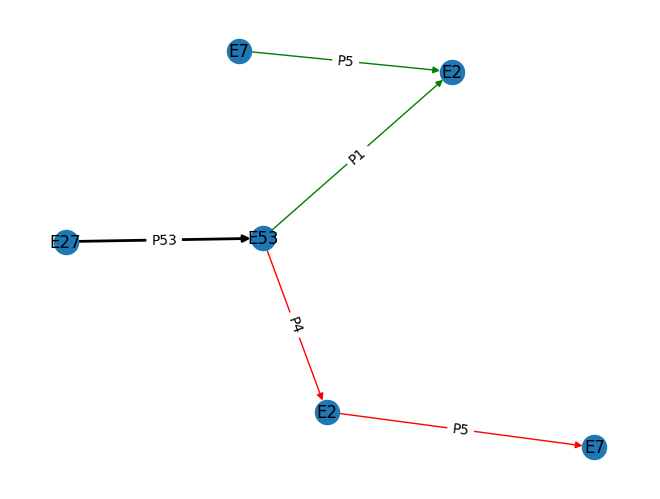

In [146]:
rows_to_duplicate = df_all_match[df_all_match['source_id'].str.contains('_both') | df_all_match['target_id'].str.contains('_both')]

# find indices of 'both' rows 
idx_both = df_all_match.index[df_all_match['source_id'].str.contains('_both') | df_all_match['target_id'].str.contains('_both')].tolist()
df_all_both = df_all_match
df_all_both['both'] = '0'
# search and replace
for both in idx_both:
	df_both_1 = df_all_both.loc[[both]]
	df_both_1['both'] = str(both) + "_1"
	df_both_1['source_id'] = df_both_1.iloc[0]['source_id'].replace('both', '1')
	df_both_1['target_id'] = df_both_1.iloc[0]['target_id'].replace('both', '1')
	df_both_2 = df_all_both.loc[[both]]
	df_both_2['source_id'] = df_both_2.iloc[0]['source_id'].replace('both', '2')
	df_both_2['target_id'] = df_both_2.iloc[0]['target_id'].replace('both', '2')
	df_both_2['both'] = str(both) + "_1"
	df_all_both = pd.concat([df_all_both, df_both_1], ignore_index=True)
	df_all_both = pd.concat([df_all_both, df_both_2], ignore_index=True)

# remove rows with 'both' patterns
idx_both = df_all_both.index[df_all_both['source_id'].str.contains('_both') | df_all_both['target_id'].str.contains('_both')].tolist()
df_all_both = df_all_both.drop(idx_both)

# print(df_all_both)

# %%
# common graph

df_both_source = df_all_both.merge(dn_all_match, right_on=['match'], left_on=['source_id'])
df_both_source = df_both_source.rename(columns={'id': 'id_source'})
df_both = df_both_source.merge(dn_all_match, right_on=['match'], left_on=['target_id'])
df_both = df_both.rename(columns={'id': 'id_target'})
# remove unuseful columns
df_both = df_both.drop(['G_y', 'G', 'match_x', 'match_y'], axis = 1)
df_both = df_both.rename(columns={'G_x': 'G'})

# print(df_both)

# %%
# replace node ids when they are 'both', stratified replacement based on 'both' tag

boths = df_both['both'].unique().tolist()
boths.remove('0')

for i in boths:
	# get the first one only, the second will be replaced
	both_row_to_keep  = df_both.index[df_both['both']==i].tolist()[0]
	id_source_to_keep = df_both.iloc[both_row_to_keep]['id_source']
	id_target_to_keep = df_both.iloc[both_row_to_keep]['id_target']
	# collect the ids of the second one
	both_row_to_change  = df_both.index[df_both['both']==i].tolist()[1]
	id_source_to_change = df_both.iloc[both_row_to_change]['id_source']
	id_target_to_change = df_both.iloc[both_row_to_change]['id_target']
	# replace ids 'to_change' by ids 'to_keep'
	# replace with the source
	df_both['id_source'] = df_both['id_source'].replace([id_source_to_change], id_source_to_keep)
	df_both['id_target'] = df_both['id_target'].replace([id_source_to_change], id_source_to_keep)
	# replace with the target
	df_both['id_source'] = df_both['id_source'].replace([id_target_to_change], id_target_to_keep)
	df_both['id_target'] = df_both['id_target'].replace([id_target_to_change], id_target_to_keep)

# print(df_both)

# %%
# plot the final graph

# colors
conditions = [
    (df_both['G'] == '1'),
    (df_both['G'] == '2')]
choices = ['red', 'green']
df_both['color'] = np.select(conditions, choices, default='black')

# load with attributes
G = nx.from_pandas_edgelist(df_both, 'id_source', 'id_target', True, create_using=nx.DiGraph())
for i in G.nodes():
     G.nodes[i]['entity'] = dn_all[dn_all['id']==i]['entity'].item()

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]

p = nx.spring_layout(G)
G_labels_nodes = nx.get_node_attributes(G, 'entity')
G_labels_edges = nx.get_edge_attributes(G, 'property')
nx.draw(G, pos=p, labels = G_labels_nodes, with_labels = True, edge_color=colors, width=weights)
nx.draw_networkx_edge_labels(G, pos=p, edge_labels = G_labels_edges)
plt.show()